# Kaggle 연습해보기

## 1.데이터

### (1)데이터 전처리

In [583]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
# from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

import seaborn as sns

In [584]:
data_dir = os.getenv('HOME')+'/workplace/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [585]:
train.head()

id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [586]:
test.head()

id             date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  15035  20141209T000000         3       2.25         2570      7242     2.0   
1  15036  20141209T000000         4       3.00         1960      5000     1.0   
2  15037  20140512T000000         4       4.50         5420    101930     1.0   
3  15038  20150415T000000         3       1.00         1780      7470     1.0   
4  15039  20150312T000000         3       2.50         1890      6560     2.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        2170            400      1951   
1           0     0          5      7        1050            910      1965   
2           0     0          3     11        3890           1530      2001   
3           0     0          3      7        1050            730      1960   
4           0     0          3      7        1890              0      2003   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0          1991    98125  47.7210 -122.319           1690        7639  
1             0    98136  47.5208 -122.393           1360        5000  
2             0    98053  47.6561 -122.005           4760      101930  
3             0    98146  47.5123 -122.337           1780        8113  
4             0    98038  47.3684 -122.031           2390        7570

### (2)데이터 전처리



이상치가 있는지 검사해본다.

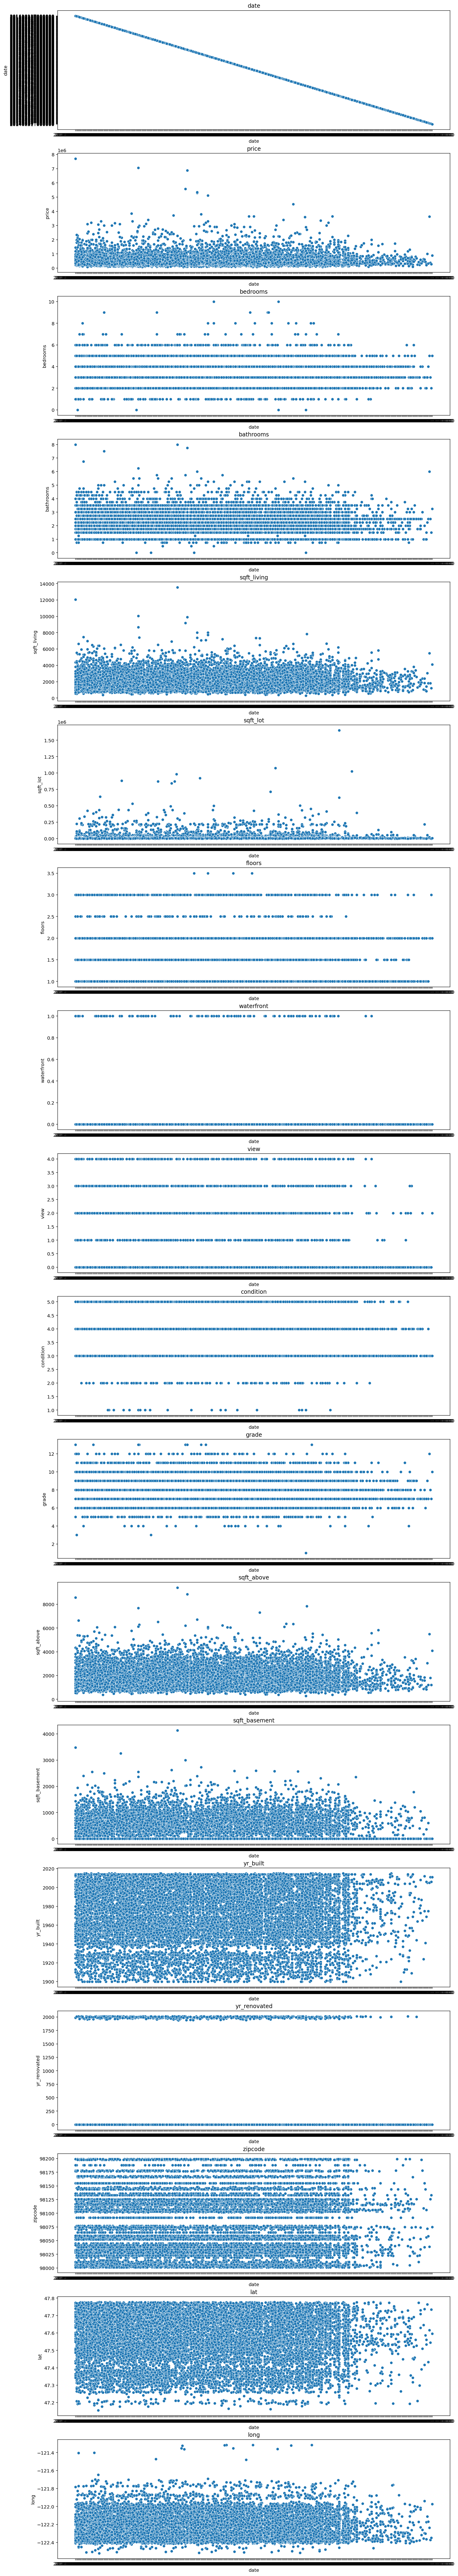

In [587]:
fig, ax = plt.subplots(18, 1, figsize=(15, 100))
count = 1
for row in range(18):
    sns.scatterplot(data=train, x=train.date, y=train.columns[count], ax=ax[row])
    ax[row].set_title(train.columns[count])
    count += 1

In [588]:
train.drop(train[train.bedrooms > 30].index, inplace=True)
train.drop(train[train.sqft_lot > 1500000].index, inplace=True)
train.drop(train[train.sqft_lot15 > 800000].index, inplace=True)

가격은 예측해야하는 값이므로 변수 y에 저장해준 후에 삭제한다.

In [589]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


전처리를 편하게하기 위해 임시로 데이터를 합친다.

In [590]:
train_len = len(train)
data = pd.concat((train, test), axis=0)

print(len(data))

21500


데이터의 결측치를 확인해본다.

In [591]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


데이터 구조를 확인해본다.

<AxesSubplot:>

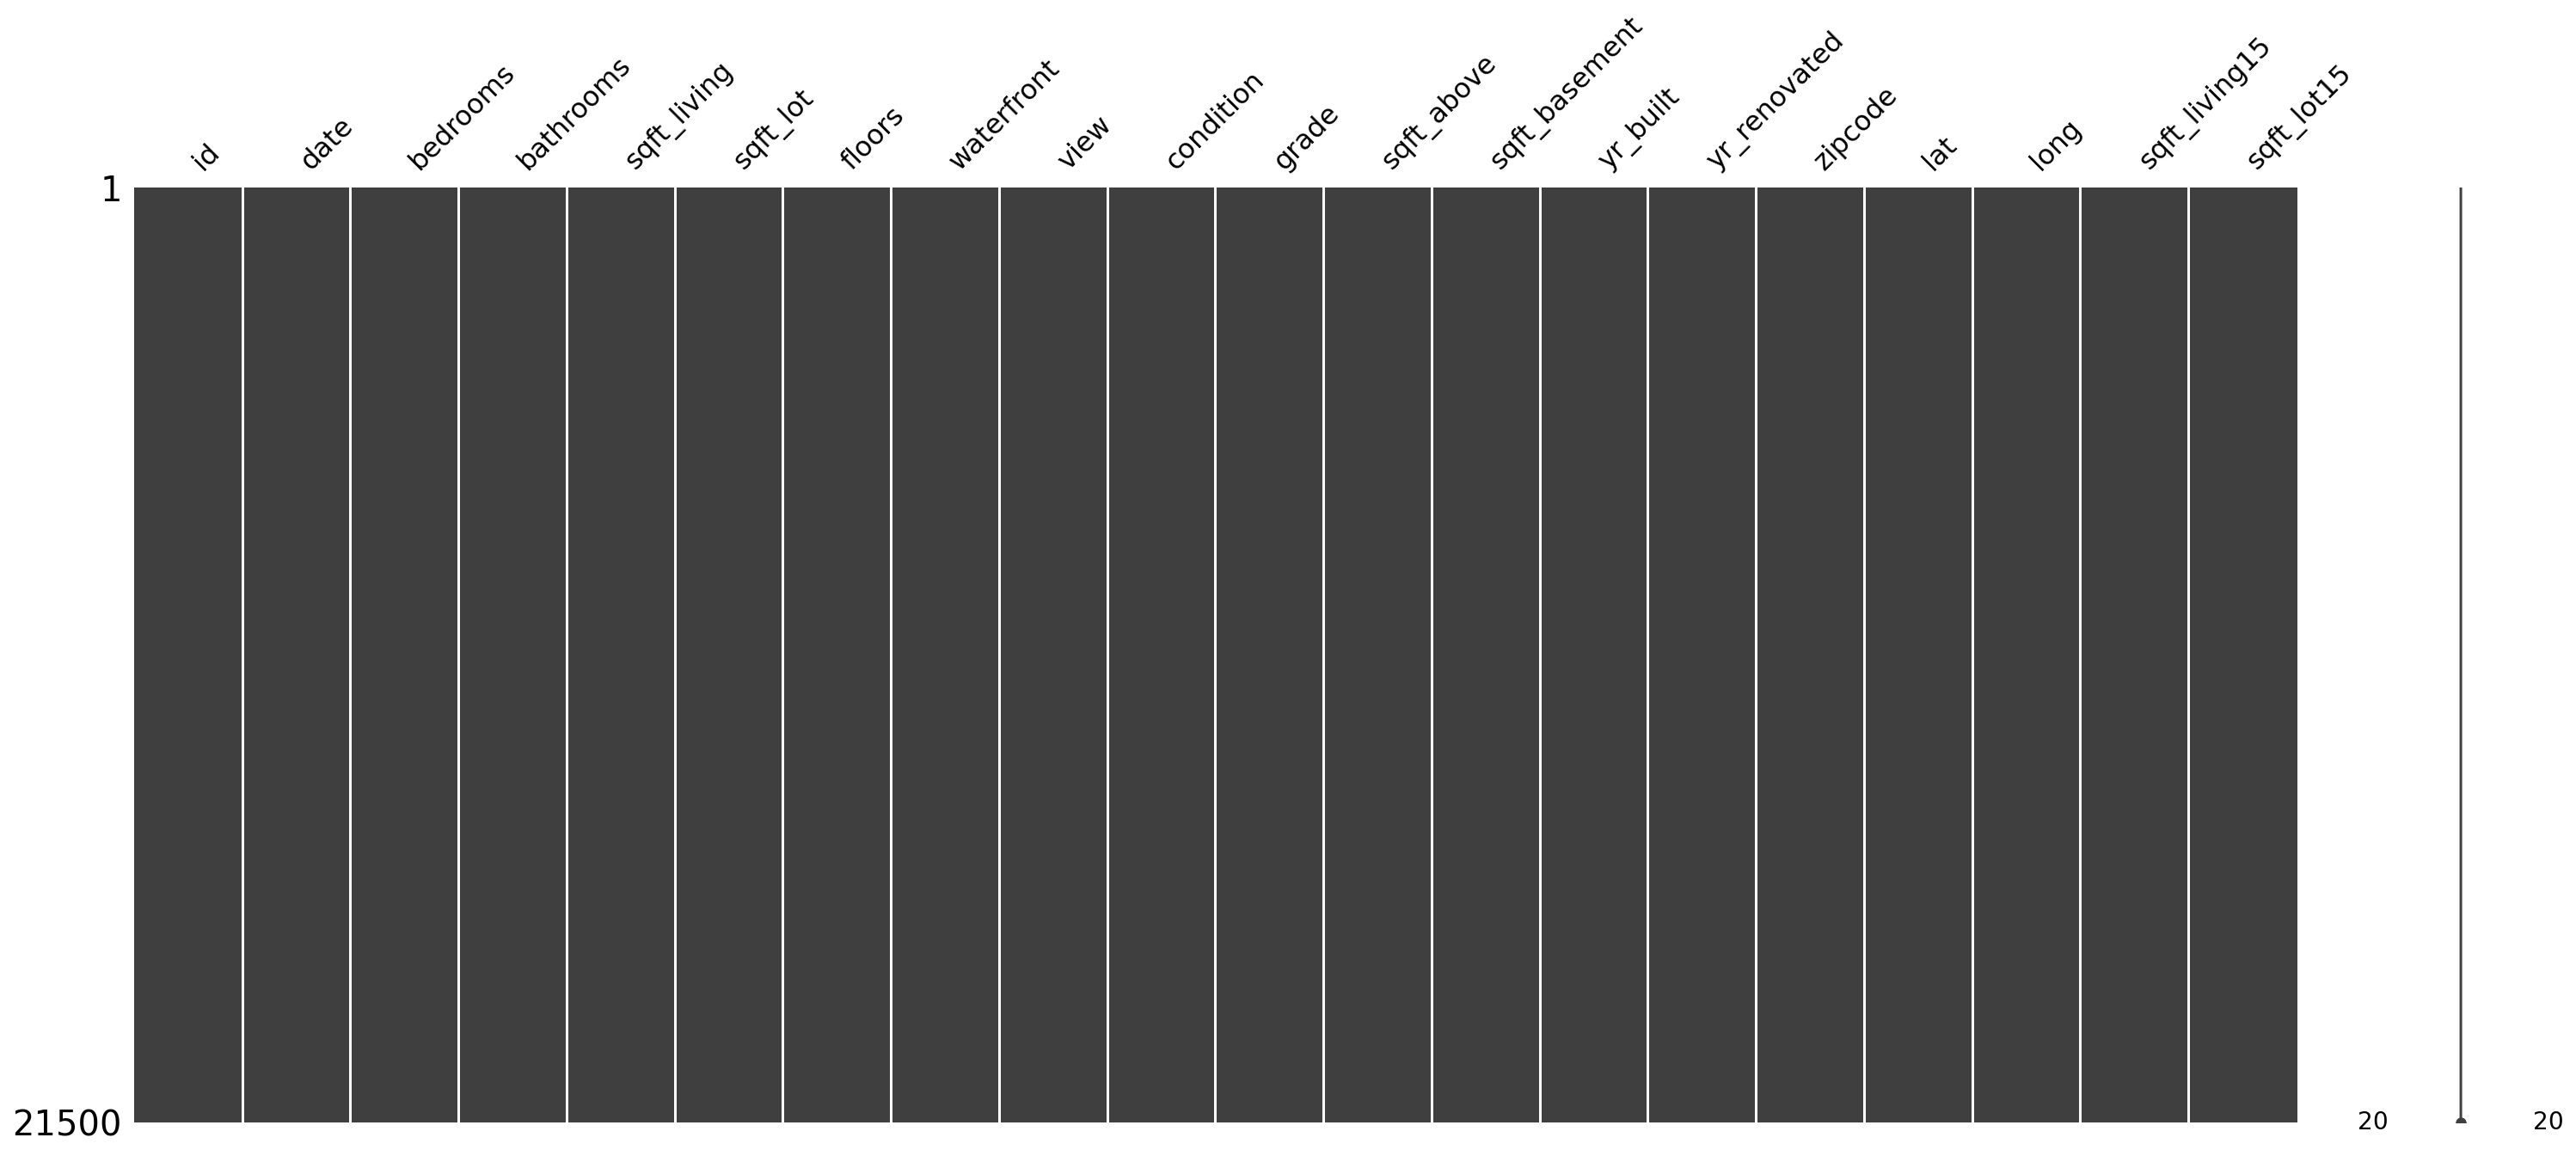

In [592]:
msno.matrix(data)

날짜를 알아보기 좋은 형태로 변환해준다.

In [593]:
data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)
data.head()

id    date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0   0  201410         3       1.00         1180      5650     1.0           0   
1   1  201502         2       1.00          770     10000     1.0           0   
2   2  201502         3       2.00         1680      8080     1.0           0   
3   3  201406         3       2.25         1715      6819     2.0           0   
4   4  201501         3       1.50         1060      9711     1.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7        1180              0      1955             0   
1     0          3      6         770              0      1933             0   
2     0          3      8        1680              0      1987             0   
3     0          3      7        1715              0      1995             0   
4     0          3      7        1060              0      1963             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  
0    98178  47.5112 -122.257           1340        5650  
1    98028  47.7379 -122.233           2720        8062  
2    98074  47.6168 -122.045           1800        7503  
3    98003  47.3097 -122.327           2238        6819  
4    98198  47.4095 -122.315           1650        9711

id는 불필요하므로 삭제를 해준다.

In [594]:
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


정확히는 알수없지만 굉장히 이상해보이는 데이터 몇가지만 삭제한다.

데이터 분포 확인

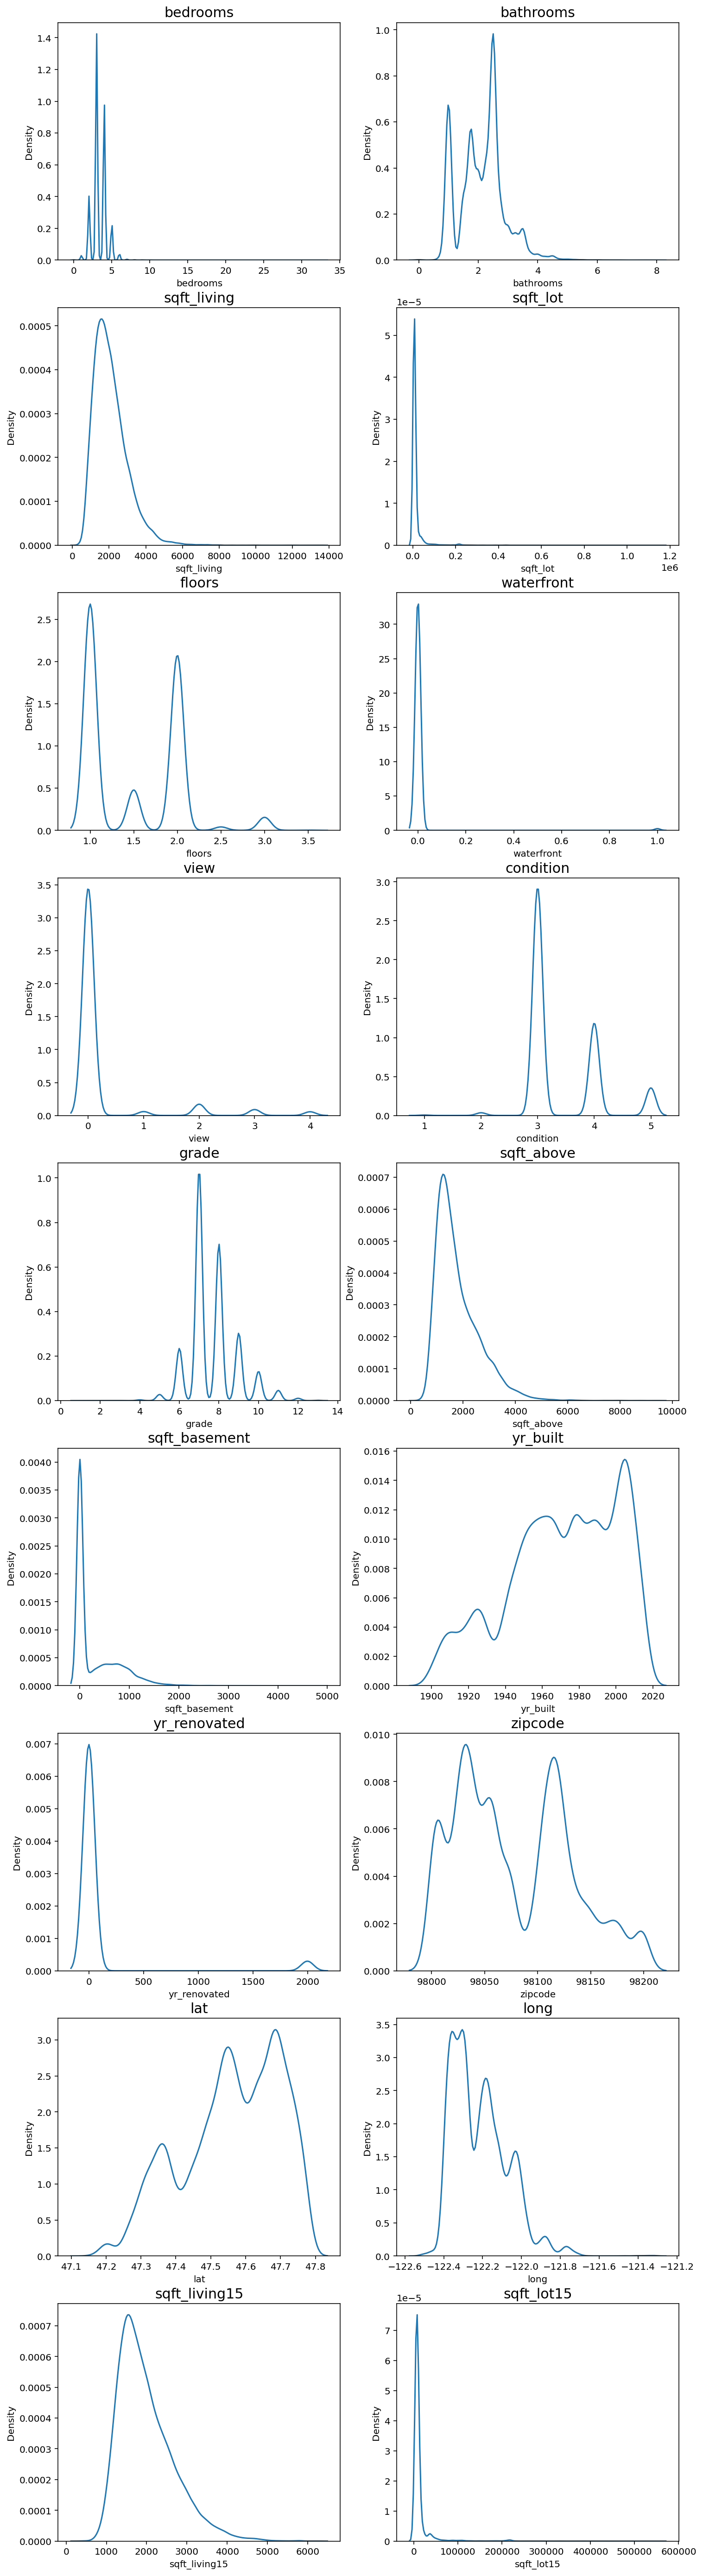

In [595]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

분포도가 너무 치우쳐져 있으면 결과를 예측하는데 안좋은 영향을 끼치기 때문에 log를 사용하여 표준분포와 가깝게 바꿔준다.

In [596]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

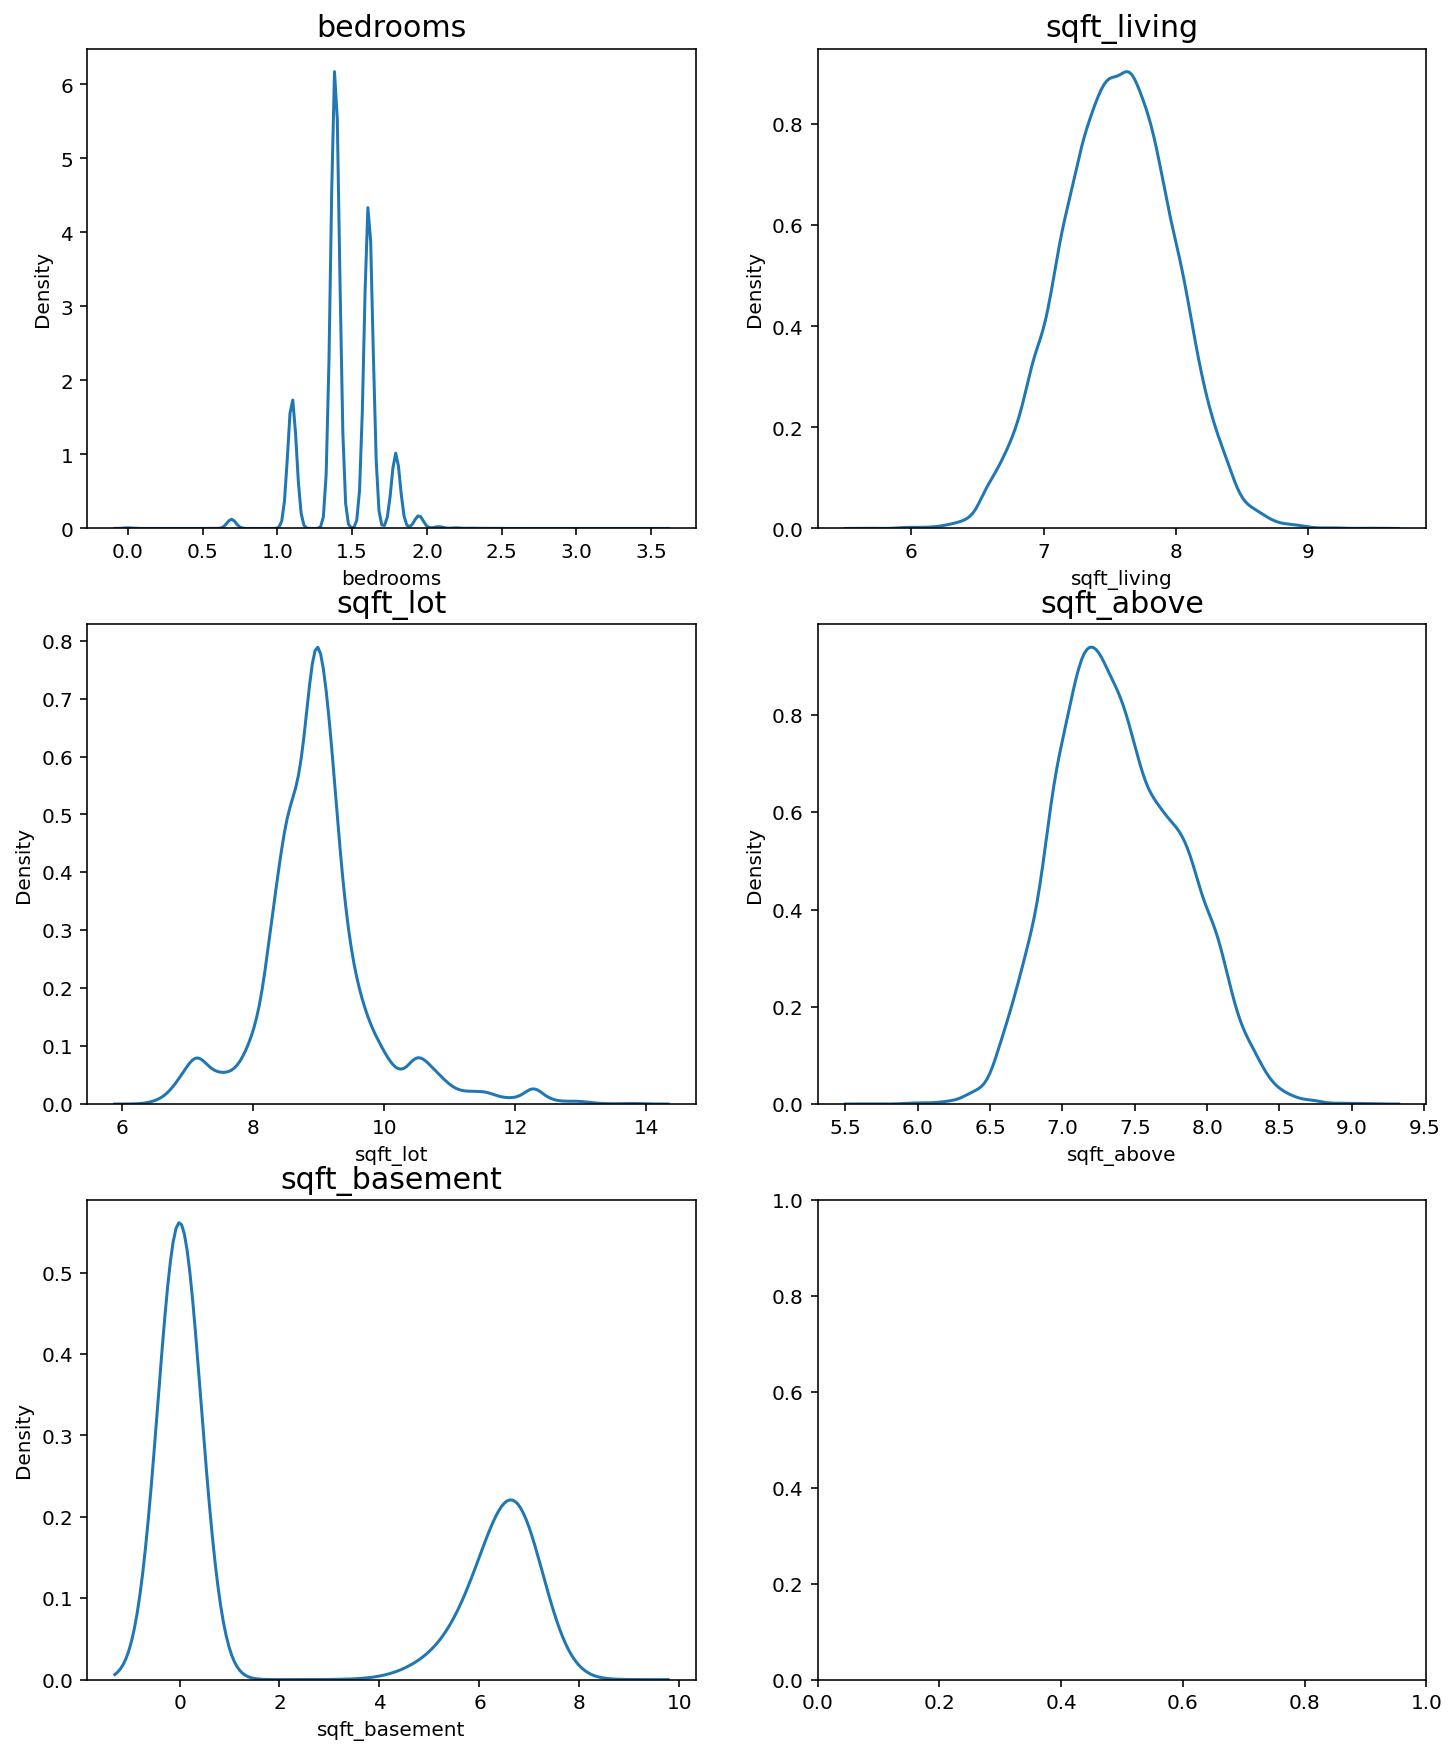

In [597]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

전처리가 끝났으니 다시 data를 train과 test로 나누어준다.

In [598]:
test = data.iloc[train_len:, :]
train = data.iloc[:train_len, :]

print(train.shape)
print(test.shape)

(15032, 19)
(6468, 19)


아까 분리해놓은 y값을 확인해본다.

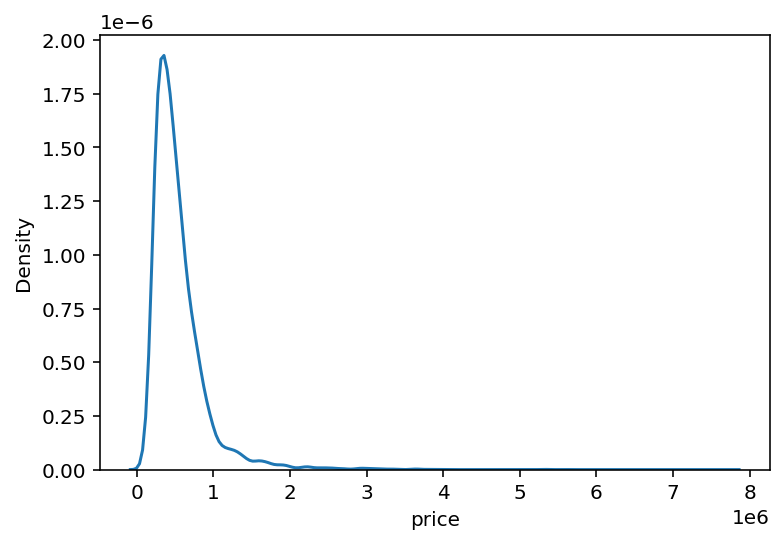

In [599]:
"""
seaborn의 `kdeplot`을 활용해 `y`의 분포를 확인해주세요!
"""
sns.kdeplot(y)
plt.show()

price도 치우쳐있으므로 같은 처리를 해준다.

In [600]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15032, dtype: float64

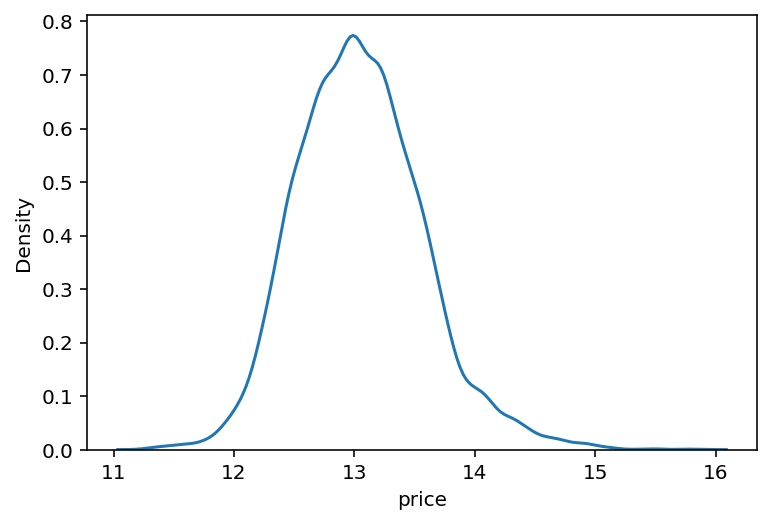

In [601]:
sns.kdeplot(y)
plt.show()

In [602]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15032 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15032 non-null  int64  
 1   bedrooms       15032 non-null  float64
 2   bathrooms      15032 non-null  float64
 3   sqft_living    15032 non-null  float64
 4   sqft_lot       15032 non-null  float64
 5   floors         15032 non-null  float64
 6   waterfront     15032 non-null  int64  
 7   view           15032 non-null  int64  
 8   condition      15032 non-null  int64  
 9   grade          15032 non-null  int64  
 10  sqft_above     15032 non-null  float64
 11  sqft_basement  15032 non-null  float64
 12  yr_built       15032 non-null  int64  
 13  yr_renovated   15032 non-null  int64  
 14  zipcode        15032 non-null  int64  
 15  lat            15032 non-null  float64
 16  long           15032 non-null  float64
 17  sqft_living15  15032 non-null  int64  
 18  sqft_l

## 2.모델

### (1)모델 및 함수 구현

In [603]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [604]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
# random_state=None    
# 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [605]:
gboost.__class__.__name__

'GradientBoostingRegressor'

RMSE 점수를 얻는 함수를 만든다.

In [606]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

get_scores(models, train, y)

RMSE
RandomForestRegressor      134874.650060
GradientBoostingRegressor  130543.190952
XGBRegressor               116500.110949
LGBMRegressor              114909.044568

하이퍼 파라미터 튜닝을 위한 그리드 검색 함수를 작성한다.

In [607]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [608]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [609]:
my_GridSearch(gboost, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:   13.0s finished


max_depth  n_estimators     score     RMSLE
3         10           100 -0.029542  0.171877
2         10            50 -0.029951  0.173064
1          1           100 -0.054940  0.234393
0          1            50 -0.073263  0.270671

In [610]:
my_GridSearch(xgboost, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:   19.6s finished


max_depth  n_estimators     score     RMSLE
2         10            50 -0.029960  0.173088
3         10           100 -0.030111  0.173527
1          1           100 -0.042970  0.207293
0          1            50 -0.048651  0.220569

In [611]:
my_GridSearch(lightgbm, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:   14.1s finished
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


max_depth  n_estimators     score     RMSLE
3         10           100 -0.027108  0.164647
2         10            50 -0.029310  0.171201
1          1           100 -0.055019  0.234562
0          1            50 -0.073344  0.270820

In [612]:
my_GridSearch(rdforest, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    8.5s finished


max_depth  n_estimators     score     RMSLE
3         10           100 -0.034976  0.187018
2         10            50 -0.035196  0.187605
1          1           100 -0.177509  0.421318
0          1            50 -0.177581  0.421403

그리드 검색결과 대체적으로 max_depth는 10 n_estimators는 100이 가장 적합한 하이퍼 파라미터로 추정된다.

## 3.테스트

모델성능을 올리기 위해서 블랜딩 함수를 작성한다.

In [613]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m.fit(x.values, y)
    
    predictions = np.column_stack([
        m.predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [614]:
y_pred = AveragingBlending(models, train, y, test)
print(len(y_pred))
y_pred

6468


array([13.13868192, 13.01176481, 14.09815597, ..., 13.039401  ,
       12.68796023, 13.0025595 ])

하이퍼 파라미터를 설정한다.

In [615]:
random_state = None

gboost = GradientBoostingRegressor(max_depth=10, n_estimators=100, random_state=random_state)
xgboost = XGBRegressor(max_depth=10, n_estimators=100, random_state=random_state)
lightgbm = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
rdforest = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [616]:
prediction = np.expm1(y_pred)
prediction

array([ 508225.20711524,  447648.03819478, 1326633.66629652, ...,
        460191.88920909,  323824.55347461,  443546.19939878])

In [617]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

# 코드 작성
def save_submission(prediction, rmsle=None):
    data_dir = os.getenv('HOME')+'/workplace/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_final.csv'.format(data_dir)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [618]:
save_submission(prediction, rmsle='0.0168')

/home/aiffel-dj13/workplace/aiffel/kaggle_kakr_housing/data/submission_final.csv saved!


## 4.회고

처음에는 이상치를 찾는데 고생을 했다. 재미있는 사실은 처음 모델을 만들었을때 private score가 115000대가 나왔는데 성능향상을 위해 이상치를 찾아 제거하고 리셈블 기법을 사용하니 오히려 점수가 120000대로 늘어났다...데이터 수는 체크하지 못했지만 그냥 모델하나만 쓰는게 더 성능이 좋아보인다.